In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Packages and Libraries

In [2]:
import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import albumentations as A
from albumentations.pytorch import ToTensorV2
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import math
from tensorflow.keras.losses import Huber
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import Add
from time import time
from tensorflow.keras.models import load_model

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU successfully assigned!")
    except RuntimeError as e:
        print(e)

✅ GPU successfully assigned!


# Functions

In [30]:
def show_img(data_set, id=0):
  benign = '0: Benign'
  malignant = '1: Malignant'
  green = (0,255,0)
  red = (0,0,255)
  if id!= 0:
    i = id
  else:
    i = np.random.randint(0, len(data_set))
  img1 = cv2.imread(data_set.img_path[i])
  img2 = cv2.imread(data_set.img_path[i])
  img_name = data_set.img_name[i]
  class_id = data_set.class_id[i]
  x_min = int((data_set.x_center[i] - (data_set.width[i] /2))*data_set.width_pxl[i])
  x_max = int((data_set.x_center[i] + (data_set.width[i] /2))*data_set.width_pxl[i])
  y_min = int((data_set.y_center[i] - (data_set.height[i]/2))*data_set.height_pxl[i])
  y_max = int((data_set.y_center[i] + (data_set.height[i]/2))*data_set.height_pxl[i])
  if class_id == 0:
    cv2.rectangle(img1, (x_min, y_min), (x_max, y_max), green, 2)
    cv2.putText(img1, benign, (x_min, y_min), cv2.FONT_HERSHEY_DUPLEX, 0.5, green, 1)
    #cv2_imshow(img1)
  else:
    cv2.rectangle(img1, (x_min, y_min), (x_max, y_max), red, 2)
    cv2.putText(img1, malignant, (x_min, y_min), cv2.FONT_HERSHEY_DUPLEX, 0.5, red, 1)
    #cv2_imshow(img1)

# Convert to RGB for Matplotlib display
  img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
  img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

  # Display images
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(img1_rgb)
  plt.axis("on")
  plt.title("Image with Bounding Box")

  plt.subplot(1, 2, 2)
  plt.imshow(img2_rgb)
  plt.axis("on")
  plt.title("Original Image")

  plt.show()
  print(img_name, x_min, x_max, y_min, y_max)

In [156]:
def resize_with_padding(image_path, target_size=(512, 512)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    old_size = image.shape[:2]  # (height, width)
    scale = min(target_size[0] / old_size[0], target_size[1] / old_size[1])

    new_size = (int(old_size[1] * scale), int(old_size[0] * scale))   #(w , h) not (h , w)

    resized = cv2.resize(image, new_size, interpolation=cv2.INTER_LANCZOS4)

    # Calculate padding
    delta_w = target_size[1] - new_size[0]  # Width difference
    delta_h = target_size[0] - new_size[1]  # Height difference

    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    # Add black padding
    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    return padded, top, bottom, left, right,scale

In [13]:
def resize_and_normalize_bbox(dataset, i):
    """
    Corrects bounding box after image resizing & padding.

    - dataset: contains images & normalized bounding boxes.
    - i: index of the sample in the dataset.

    Returns: [x_center_norm, y_center_norm, width_norm, height_norm]
    """
    # Load image path
    img = dataset.img_path[i]

    # Get padding values after resizing
    _, top, _, left, _, scale = resize_with_padding(img)

    # Convert YOLO normalized bbox to absolute pixel values (before resizing)
    x_min_r = (dataset.x_center[i] - (dataset.width[i] / 2)) * dataset.width_pxl[i]
    x_max_r = (dataset.x_center[i] + (dataset.width[i] / 2)) * dataset.width_pxl[i]
    y_min_r = (dataset.y_center[i] - (dataset.height[i] / 2)) * dataset.height_pxl[i]
    y_max_r = (dataset.y_center[i] + (dataset.height[i] / 2)) * dataset.height_pxl[i]


    x_min_r *= scale
    x_max_r *= scale
    y_min_r *= scale
    y_max_r *= scale


    x_min_r += left
    x_max_r += left
    y_min_r += top
    y_max_r += top


    x_new_norm = ((x_min_r + x_max_r) / 2) / 512
    y_new_norm = ((y_min_r + y_max_r) / 2) / 512
    w_new_norm = (x_max_r - x_min_r) / (512)  # No padding added here
    h_new_norm = (y_max_r - y_min_r) / (512)  # No padding added here

    return [x_new_norm, y_new_norm, w_new_norm, h_new_norm]

In [157]:
def save_image(data_set, path):

  for i in range(len(data_set)):

    img_name = data_set.img_name[i]
    class_id = data_set.class_id[i]
    img_path = data_set.img_path[i]
    dest_path = path

    img1, top, bottom, left, right,scale = resize_with_padding(img_path, (512,512))
    cv2.imwrite(dest_path+img_name+'.jpg', img1)
    print(f'{i} Out Of {len(data_set)}')

# DataSet Preperation
if DataSet is Avaialble, Jump to Resize Dataset
if Dataset is Resized, Jump to Read Prepared Dataset

## Initial Dataset Preperation

In [15]:
train_path = '/content/drive/MyDrive/SDS CP#24/DataSet/train'
valid_path = '/content/drive/MyDrive/SDS CP#24/DataSet/valid'

In [16]:
train_df = pd.DataFrame(columns=['img_name','img_path','class_id','x_center','y_center','width','height'])

In [17]:
j=0
for i in os.listdir(train_path+'/labels'):
  with open(train_path+'/labels/'+i, 'r') as f:
    img_name = i.split('.')[0]
    img_path = train_path+'/images/'+img_name+'.jpg'
    for line in f:
      class_id, x_min, x_max, y_min, y_max = line.split()
      img_name = str(j)+'-'+img_name
      train_df.loc[len(train_df)] = [img_name, img_path, class_id, x_min, x_max, y_min, y_max]
      j+=1

In [18]:
train_df.head()

,img_name,img_path,class_id,x_center,y_center,width,height
0,0-00064_140,/content/drive/MyDrive/SDS CP#24/DataSet/train...,0,0.360329,0.370305,0.173709,0.174883
1,1-00056_129,/content/drive/MyDrive/SDS CP#24/DataSet/train...,1,0.520540,0.448944,0.233568,0.132629
2,2-00060_71,/content/drive/MyDrive/SDS CP#24/DataSet/train...,1,0.524061,0.452465,0.172535,0.139671
3,3-00059_122,/content/drive/MyDrive/SDS CP#24/DataSet/train...,1,0.460681,0.404343,0.174883,0.111502
4,4-00061_127,/content/drive/MyDrive/SDS CP#24/DataSet/train...,0,0.569249,0.485329,0.091549,0.085681


In [19]:
len(train_df)

925

In [20]:
train_df.class_id.value_counts()

,count
class_id,
1,488
0,437


In [21]:
valid_df = pd.DataFrame(columns=['img_name','img_path','class_id','x_center','y_center','width','height'])

In [22]:
j=0
for i in os.listdir(valid_path+'/labels'):
  with open(valid_path+'/labels/'+i, 'r') as f:
    img_name = i.split('.')[0]
    img_path = valid_path+'/images/'+img_name+'.jpg'
    for line in f:
      class_id, x_min, x_max, y_min, y_max = line.split()
      img_name = str(j)+'-'+img_name
      valid_df.loc[len(valid_df)] = [img_name, img_path, class_id, x_min, x_max, y_min, y_max]
      j+=1

In [23]:
valid_df.head()

,img_name,img_path,class_id,x_center,y_center,width,height
0,0-val_1 (107),/content/drive/MyDrive/SDS CP#24/DataSet/valid...,1,0.731808,0.234742,0.113850,0.107981
1,1-val_1 (132),/content/drive/MyDrive/SDS CP#24/DataSet/valid...,0,0.605047,0.444249,0.102113,0.106808
2,2-val_1 (116),/content/drive/MyDrive/SDS CP#24/DataSet/valid...,0,0.641432,0.401408,0.137324,0.126761
3,3-val_1 (133),/content/drive/MyDrive/SDS CP#24/DataSet/valid...,0,0.598592,0.430164,0.105634,0.095070
4,4-val_1 (117),/content/drive/MyDrive/SDS CP#24/DataSet/valid...,1,0.447770,0.236502,0.120892,0.102113


In [24]:
valid_df.class_id.value_counts()

,count
class_id,
0,154
1,87


In [25]:
len(valid_df)

241

In [26]:
for i in range(len(train_df)):
  img = cv2.imread(train_df.img_path[i])
  width_pxl = int(img.shape[1])
  height_pxl = int(img.shape[0])
  channels = int(img.shape[2])
  train_df.loc[i,'width_pxl'] = width_pxl
  train_df.loc[i,'height_pxl'] = height_pxl
  train_df.loc[i,'channels'] = channels

In [27]:
for i in range(len(valid_df)):
  img = cv2.imread(valid_df.img_path[i])
  width_pxl = int(img.shape[1])
  height_pxl = int(img.shape[0])
  channels = int(img.shape[2])
  valid_df.loc[i,'width_pxl'] = width_pxl
  valid_df.loc[i,'height_pxl'] = height_pxl
  valid_df.loc[i,'channels'] = channels

In [54]:
train_df.to_csv('/content/drive/MyDrive/SDS CP#24/DataSet/train/train_df.csv', index=False)

In [55]:
valid_df.to_csv('/content/drive/MyDrive/SDS CP#24/DataSet/valid/valid_df.csv', index=False)

### Testing Generated Dataset

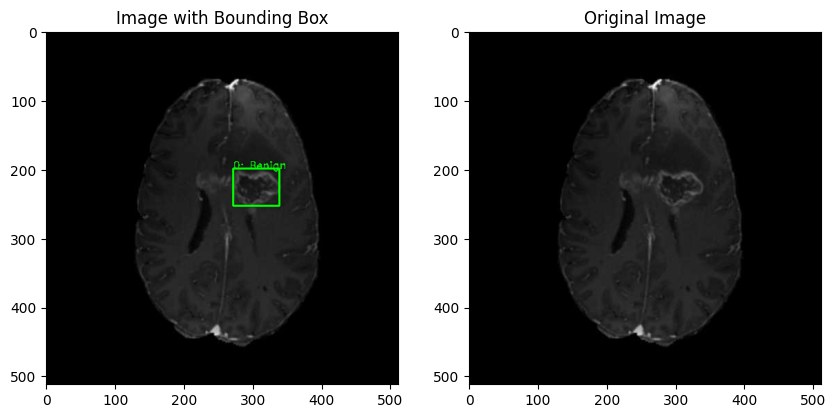

50-val_1 (129) 271 338 199 253


In [65]:
show_img(valid_df)

## Resizing Images and convert to grey scale

### Resixe to 512X512

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/SDS CP#24/DataSet/train/train_df.csv', index_col=False)
valid_df = pd.read_csv('/content/drive/MyDrive/SDS CP#24/DataSet/valid/valid_df.csv', index_col=False)

In [ ]:
train_df.shape

(925, 10)

In [180]:
train_df_resized = train_df.copy()
valid_df_resized = valid_df.copy()

In [181]:
train_df_resized.loc[:,['width_pxl', 'height_pxl']] = 512
valid_df_resized.loc[:,['width_pxl', 'height_pxl']] = 512

In [182]:
for i in range(len(train_df)):
  train_df_resized.loc[i,'x_center'] = resize_and_normalize_bbox(train_df, i)[0]
  train_df_resized.loc[i,'y_center'] = resize_and_normalize_bbox(train_df, i)[1]
  train_df_resized.loc[i,'width'] = resize_and_normalize_bbox(train_df, i)[2]
  train_df_resized.loc[i,'height'] = resize_and_normalize_bbox(train_df, i)[3]

In [183]:
for i in range(len(valid_df)):
  valid_df_resized.loc[i,'x_center'] = resize_and_normalize_bbox(valid_df, i)[0]
  valid_df_resized.loc[i,'y_center'] = resize_and_normalize_bbox(valid_df, i)[1]
  valid_df_resized.loc[i,'width'] = resize_and_normalize_bbox(valid_df, i)[2]
  valid_df_resized.loc[i,'height'] = resize_and_normalize_bbox(valid_df, i)[3]

In [184]:
path = '/content/drive/MyDrive/SDS CP#24/DataSet/train/images_resized/'
for i in range(len(train_df_resized)):
  img_name = train_df_resized.loc[i, 'img_name']
  new_path = path+img_name+'.jpg'
  train_df_resized.loc[i, 'img_path'] = new_path

In [185]:
path = '/content/drive/MyDrive/SDS CP#24/DataSet/valid/images_resized/'
for i in range(len(valid_df)):
  img_name = valid_df.loc[i, 'img_name']
  new_path = path+img_name+'.jpg'
  valid_df_resized.loc[i, 'img_path'] = new_path

In [186]:
train_df_resized.to_csv('/content/drive/MyDrive/SDS CP#24/DataSet/train/train_df_resized.csv', index=False)

In [217]:
valid_df_resized.to_csv('/content/drive/MyDrive/SDS CP#24/DataSet/valid/valid_df_resized.csv', index=False)

In [81]:
train_df_resized.img_path[0]

'/content/drive/MyDrive/SDS CP#24/DataSet/train/images_resized/0-00064_140.jpg'

In [82]:
train_df_resized.shape

(925, 10)

In [83]:
valid_df_resized.shape

(241, 10)

In [158]:
train_df.loc[0,'img_path']

'/content/drive/MyDrive/SDS CP#24/DataSet/train/images/00064_140.jpg'

In [85]:
train_df_resized.loc[0,'img_path']

'/content/drive/MyDrive/SDS CP#24/DataSet/train/images_resized/0-00064_140.jpg'

### Save Resized Images

In [159]:
save_image(train_df, '/content/drive/MyDrive/SDS CP#24/DataSet/train/images_resized/')

0 Out Of 925
1 Out Of 925
2 Out Of 925
3 Out Of 925
4 Out Of 925
5 Out Of 925
6 Out Of 925
7 Out Of 925
8 Out Of 925
9 Out Of 925
10 Out Of 925
11 Out Of 925
12 Out Of 925
13 Out Of 925
14 Out Of 925
15 Out Of 925
16 Out Of 925
17 Out Of 925
18 Out Of 925
19 Out Of 925
20 Out Of 925
21 Out Of 925
22 Out Of 925
23 Out Of 925
24 Out Of 925
25 Out Of 925
26 Out Of 925
27 Out Of 925
28 Out Of 925
29 Out Of 925
30 Out Of 925
31 Out Of 925
32 Out Of 925
33 Out Of 925
34 Out Of 925
35 Out Of 925
36 Out Of 925
37 Out Of 925
38 Out Of 925
39 Out Of 925
40 Out Of 925
41 Out Of 925
42 Out Of 925
43 Out Of 925
44 Out Of 925
45 Out Of 925
46 Out Of 925
47 Out Of 925
48 Out Of 925
49 Out Of 925
50 Out Of 925
51 Out Of 925
52 Out Of 925
53 Out Of 925
54 Out Of 925
55 Out Of 925
56 Out Of 925
57 Out Of 925
58 Out Of 925
59 Out Of 925
60 Out Of 925
61 Out Of 925
62 Out Of 925
63 Out Of 925
64 Out Of 925
65 Out Of 925
66 Out Of 925
67 Out Of 925
68 Out Of 925
69 Out Of 925
70 Out Of 925
71 Out Of 925
72

In [235]:
save_image(valid_df, '/content/drive/MyDrive/SDS CP#24/DataSet/valid/images_resized/')

0 Out Of 241
1 Out Of 241
2 Out Of 241
3 Out Of 241
4 Out Of 241
5 Out Of 241
6 Out Of 241
7 Out Of 241
8 Out Of 241
9 Out Of 241
10 Out Of 241
11 Out Of 241
12 Out Of 241
13 Out Of 241
14 Out Of 241
15 Out Of 241
16 Out Of 241
17 Out Of 241
18 Out Of 241
19 Out Of 241
20 Out Of 241
21 Out Of 241
22 Out Of 241
23 Out Of 241
24 Out Of 241
25 Out Of 241
26 Out Of 241
27 Out Of 241
28 Out Of 241
29 Out Of 241
30 Out Of 241
31 Out Of 241
32 Out Of 241
33 Out Of 241
34 Out Of 241
35 Out Of 241
36 Out Of 241
37 Out Of 241
38 Out Of 241
39 Out Of 241
40 Out Of 241
41 Out Of 241
42 Out Of 241
43 Out Of 241
44 Out Of 241
45 Out Of 241
46 Out Of 241
47 Out Of 241
48 Out Of 241
49 Out Of 241
50 Out Of 241
51 Out Of 241
52 Out Of 241
53 Out Of 241
54 Out Of 241
55 Out Of 241
56 Out Of 241
57 Out Of 241
58 Out Of 241
59 Out Of 241
60 Out Of 241
61 Out Of 241
62 Out Of 241
63 Out Of 241
64 Out Of 241
65 Out Of 241
66 Out Of 241
67 Out Of 241
68 Out Of 241
69 Out Of 241
70 Out Of 241
71 Out Of 241
72

### Test Generated Dataset

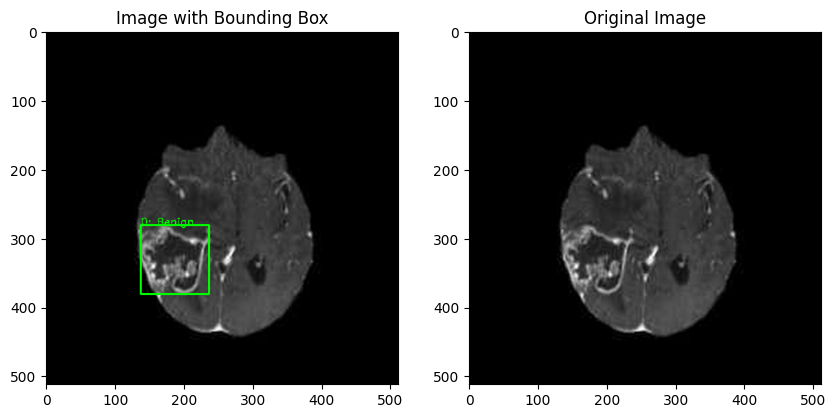

259-00158_90 137 236 281 381


In [189]:
show_img(train_df_resized)

In [218]:
train_df_resized = pd.read_csv('/content/drive/MyDrive/SDS CP#24/DataSet/train/train_df_resized.csv', index_col=False)
valid_df_resized = pd.read_csv('/content/drive/MyDrive/SDS CP#24/DataSet/valid/valid_df_resized.csv', index_col=False)

In [219]:
train_df_resized.shape

(1850, 10)

## Images Augmentation

In [168]:
transform = A.Compose([
    A.RandomBrightnessContrast(p=1),
    A.GaussNoise(p=1),
    A.Blur(blur_limit=3, p=1)
])

In [169]:
def augment_image(image):
    transformed = transform(image=image)
    return transformed['image']

In [190]:
augment = pd.DataFrame(columns=['img_name','img_path','class_id','x_center','y_center','width','height', 'width_pxl', 'height_pxl', 'channels'])

In [191]:
dest_path = '/content/drive/MyDrive/SDS CP#24/DataSet/train/images_resized/'
for i in range(len(train_df_resized)):
  img_path = train_df_resized.loc[i, 'img_path']
  img_name = train_df_resized.loc[i, 'img_name']
  img_class = train_df_resized.loc[i, 'class_id']
  x_center = train_df_resized.loc[i, 'x_center']
  y_center = train_df_resized.loc[i, 'y_center']
  width = train_df_resized.loc[i, 'width']
  height = train_df_resized.loc[i, 'height']
  width_pxl = train_df_resized.loc[i, 'width_pxl']
  height_pxl = train_df_resized.loc[i, 'height_pxl']
  channels = train_df_resized.loc[i, 'channels']
  img_new_name = 'A-'+img_name
  '''image = cv2.imread(img_path)
  aug_image = augment_image(image)


  cv2.imwrite(dest_path+img_new_name+'.jpg', aug_image)'''
  augment.loc[len(augment)] = [img_new_name, dest_path+img_new_name+'.jpg', img_class, x_center, y_center, width, height, width_pxl, height_pxl, channels]
  print(f'{i} Out Of {len(train_df_resized)}')

0 Out Of 925
1 Out Of 925
2 Out Of 925
3 Out Of 925
4 Out Of 925
5 Out Of 925
6 Out Of 925
7 Out Of 925
8 Out Of 925
9 Out Of 925
10 Out Of 925
11 Out Of 925
12 Out Of 925
13 Out Of 925
14 Out Of 925
15 Out Of 925
16 Out Of 925
17 Out Of 925
18 Out Of 925
19 Out Of 925
20 Out Of 925
21 Out Of 925
22 Out Of 925
23 Out Of 925
24 Out Of 925
25 Out Of 925
26 Out Of 925
27 Out Of 925
28 Out Of 925
29 Out Of 925
30 Out Of 925
31 Out Of 925
32 Out Of 925
33 Out Of 925
34 Out Of 925
35 Out Of 925
36 Out Of 925
37 Out Of 925
38 Out Of 925
39 Out Of 925
40 Out Of 925
41 Out Of 925
42 Out Of 925
43 Out Of 925
44 Out Of 925
45 Out Of 925
46 Out Of 925
47 Out Of 925
48 Out Of 925
49 Out Of 925
50 Out Of 925
51 Out Of 925
52 Out Of 925
53 Out Of 925
54 Out Of 925
55 Out Of 925
56 Out Of 925
57 Out Of 925
58 Out Of 925
59 Out Of 925
60 Out Of 925
61 Out Of 925
62 Out Of 925
63 Out Of 925
64 Out Of 925
65 Out Of 925
66 Out Of 925
67 Out Of 925
68 Out Of 925
69 Out Of 925
70 Out Of 925
71 Out Of 925
72

In [194]:
train_df_resized.shape

(1850, 10)

In [193]:
train_df_resized = pd.concat([train_df_resized, augment], ignore_index=True)

In [216]:
train_df_resized.to_csv('/content/drive/MyDrive/SDS CP#24/DataSet/train/train_df_resized.csv', index=False)

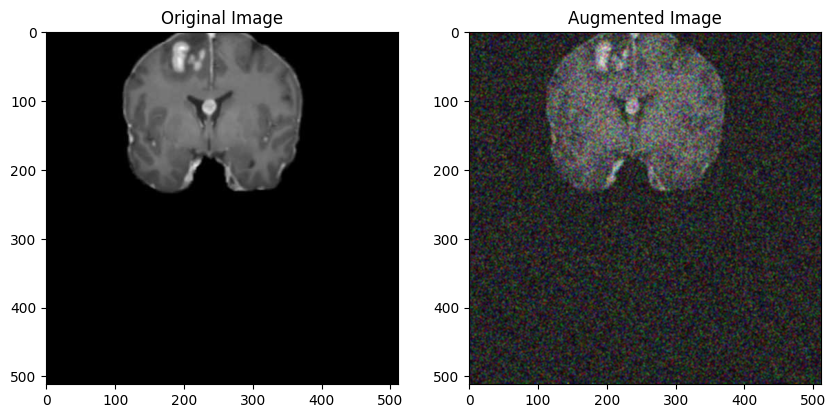

In [201]:
i = np.random.randint(0, len(train_df_resized))
if i >924:
  i = i-925
path = train_df_resized.loc[i, 'img_path']
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
aug_image = augment_image(image)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image)
axs[0].set_title("Original Image")

axs[1].imshow(aug_image)
axs[1].set_title("Augmented Image")

plt.show()

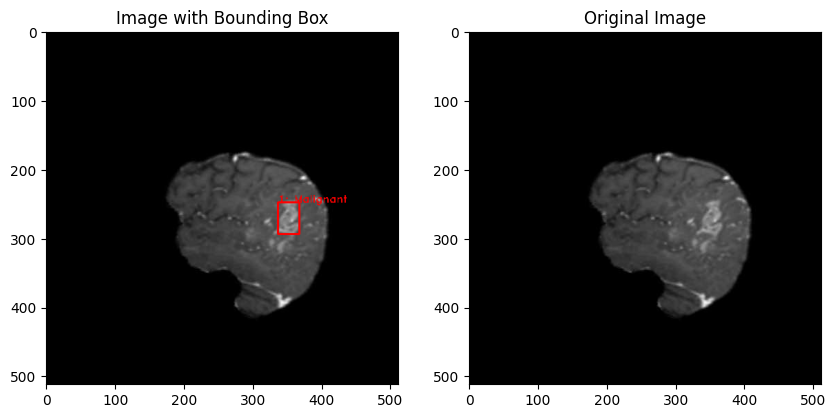

391-00185_289 336 367 248 294


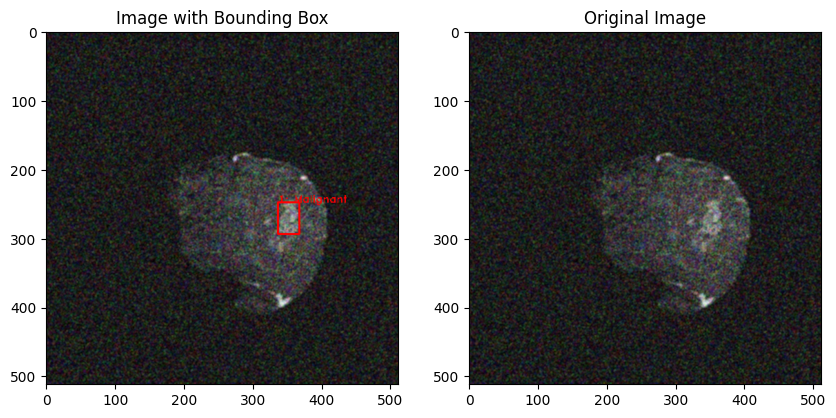

A-391-00185_289 336 367 248 294


In [204]:
i = np.random.randint(0, len(train_df_resized))
if i > 924:
  j= i-925
else:
  j = i+925


show_img(train_df_resized, i)

show_img(train_df_resized, j)


# Model Building

In [223]:
training_df = pd.read_csv('/content/drive/MyDrive/SDS CP#24/DataSet/train/train_df_resized.csv', index_col=False)

In [222]:
validation_df = pd.read_csv('/content/drive/MyDrive/SDS CP#24/DataSet/valid/valid_df_resized.csv', index_col=False)

In [207]:
training_df.head()

,img_name,img_path,class_id,x_center,y_center,width,height,width_pxl,height_pxl,channels
0,0-00064_140,/content/drive/MyDrive/SDS CP#24/DataSet/train...,0,0.360329,0.370305,0.173709,0.174883,512.0,512.0,3.0
1,1-00056_129,/content/drive/MyDrive/SDS CP#24/DataSet/train...,1,0.520540,0.448944,0.233568,0.132629,512.0,512.0,3.0
2,2-00060_71,/content/drive/MyDrive/SDS CP#24/DataSet/train...,1,0.524061,0.452465,0.172535,0.139671,512.0,512.0,3.0
3,3-00059_122,/content/drive/MyDrive/SDS CP#24/DataSet/train...,1,0.460681,0.404343,0.174883,0.111502,512.0,512.0,3.0
4,4-00061_127,/content/drive/MyDrive/SDS CP#24/DataSet/train...,0,0.569249,0.485329,0.091549,0.085681,512.0,512.0,3.0


In [210]:
# Input Layer
inputs = Input(shape=(512, 512, 3))

# Conv1
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.BatchNormalization()(x)

# Conv2
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.BatchNormalization()(x)

# Conv3
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.BatchNormalization()(x)

# Conv4
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.BatchNormalization()(x)

residual = layers.Dense(256, activation="relu")(x)  # Residual connection
residual = layers.Dense(256, activation="relu")(residual)
x = Add()([x, residual])  # Add residual connection

# Flattening
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Classification Network
classification_output = layers.Dense(2, activation='softmax', name='classification')(x)

# Regression Network
bbox_output = layers.Dense(4, activation = 'relu', name='bbox', kernel_initializer=HeNormal())(x)

In [211]:
model = Model(inputs=inputs, outputs=[classification_output, bbox_output])

In [236]:
model.compile(optimizer='adam',
                  loss={"classification": 'categorical_crossentropy', "bbox": MeanAbsoluteError()},
                  metrics={"classification": ["accuracy", tf.keras.metrics.Recall()], "bbox": 'mae'},
              loss_weights= {'classification': 3.0, 'bbox': 1.0})

In [ ]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 512, 512, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 512, 512, 32)   │            896 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_18          │ (None, 256, 256, 32)   │              0 │ conv2d_18[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 256, 256, 32)   │            128 │ max_pooling2d_18[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 256, 256, 64)   │         18,496 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_19          │ (None, 128, 128, 64)   │              0 │ conv2d_19[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 128, 128, 64)   │            256 │ max_pooling2d_19[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_20          │ (None, 64, 64, 128)    │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 64, 64, 128)    │            512 │ max_pooling2d_20[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_21          │ (None, 32, 32, 256)    │              0 │ conv2d_21[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 32, 32, 256)    │          1,024 │ max_pooling2d_21[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 32, 32, 256)    │         65,792 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 32, 32, 256)    │         65,792 │ dense_5[0][0]          │
├──────────────────────

 Total params: 134,743,238 (514.00 MB)

 Trainable params: 134,742,278 (514.00 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
len(model.layers)

21

In [225]:
def batch_generator(df, batch_size=32):
    while True:
        # Generate random batch indices
        image_nums = np.random.randint(0, df.shape[0], size=batch_size)

        # Create empty arrays
        batch_images = np.zeros((batch_size, 512, 512, 3), dtype=np.float32)  # Ensure float32
        batch_labels = np.zeros((batch_size,), dtype=np.int32)  # Ensure int32
        batch_bboxes = np.zeros((batch_size, 4), dtype=np.float32)  # Ensure float32

        valid_samples = 0  # Track valid data points

        for i in range(batch_size):
              # Load and preprocess image
              img_path = df.loc[image_nums[i], 'img_path']
              img = tf.keras.preprocessing.image.load_img(img_path)
              img_array = tf.keras.preprocessing.image.img_to_array(img)
              batch_images[i] = img_array / 255.0  # Normalize

              # Read and assign classification label (ensure int32)
              batch_labels[i] = int(df.loc[image_nums[i], 'class_id'])

              # Read bounding box values (ensure float32)
              batch_bboxes[i] = np.array([
                  df.loc[image_nums[i], 'x_center'],
                  df.loc[image_nums[i], 'y_center'],
                  df.loc[image_nums[i], 'width'],
                  df.loc[image_nums[i], 'height']
              ], dtype=np.float32)

        batch_labels = tf.keras.utils.to_categorical(batch_labels, num_classes=2).astype(np.int32)
        # Ensure batch is not empty before yielding
        yield batch_images, {
            "classification": batch_labels,
            "bbox": batch_bboxes
        }

In [226]:
sample_batch = next(batch_generator(training_df, 32))

In [227]:
_, sample_labels = sample_batch
true_bboxes = sample_labels["bbox"]

# Print bbox labels
print("📍 True Bounding Boxes:\n", true_bboxes[:5])  # Show first 5 bbox labels

📍 True Bounding Boxes:
 [[0.411972   0.284624   0.147887   0.188967  ]
 [0.49882624 0.569836   0.10798125 0.123239  ]
 [0.3527     0.376174   0.153756   0.144366  ]
 [0.680751   0.38615    0.112676   0.107981  ]
 [0.345657   0.360915   0.116197   0.116197  ]]


In [228]:
debug_model = Model(inputs=model.input, outputs=model.get_layer("bbox").output)

# Predict using the new debug model
raw_bboxes = debug_model.predict(sample_batch[0])

# Print raw bounding box predictions before activation
print("🔍 Raw Bounding Box Predictions:\n", raw_bboxes[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
🔍 Raw Bounding Box Predictions:
 [[0.01012858 0.00016914 0.00024157 0.        ]
 [0.02213012 0.00054516 0.04088465 0.04714074]
 [0.01752957 0.00553712 0.01400571 0.02601007]
 [0.         0.         0.00326824 0.        ]
 [0.00294848 0.         0.         0.        ]]


In [229]:
sample_batch[1]['classification'].shape

(32, 2)

In [231]:
sample_batch[1]['bbox'].shape

(32, 4)

In [ ]:
sample_batch = next(batch_generator(validation_df, batch_size=4))
print(sample_batch[1]["classification"].dtype)  # Should be int32
print(sample_batch[1]["bounding_box"].dtype)  # Should be float32

int32
float32


In [ ]:
print("Batch Labels:", sample_batch[1]["classification"])  # Check shape & values
print("Batch BBoxes:", sample_batch[1]["bounding_box"])  # Check bounding box values

Batch Labels: [0 1 1 1]
Batch BBoxes: [[0.635563 0.090962 0.102113 0.083333]
 [0.61385  0.407277 0.08216  0.08216 ]
 [0.607394 0.557512 0.073944 0.089202]
 [0.321596 0.390258 0.061033 0.09507 ]]


In [ ]:
training_df.img_path[0]

'/content/drive/MyDrive/SDS CP#24/DataSet/train/training_images/0-00064_140.jpg'

In [237]:
batchsize = 32
train_generator = batch_generator(training_df, batch_size=batchsize)
val_generator = batch_generator(validation_df, batch_size=batchsize)
steps_per_epoch = max(1, len(training_df) // batchsize)
validation_steps = max(1, len(validation_df) // batchsize)
early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [238]:
start = time()
history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=10,
        validation_data=val_generator,
        validation_steps=validation_steps,
        batch_size=batchsize,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )
end = time()
print(f'Time Taken: {(end-start)/60} min')

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 39s 530ms/step - bbox_loss: 0.4715 - bbox_mae: 0.4715 - classification_accuracy: 0.5320 - classification_loss: 1.3968 - classification_recall_1: 0.5320 - loss: 4.6618 - val_bbox_loss: 0.2756 - val_bbox_mae: 0.2756 - val_classification_accuracy: 0.4018 - val_classification_loss: 0.6939 - val_classification_recall_1: 0.4018 - val_loss: 2.3573 - learning_rate: 0.0010
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 38s 671ms/step - bbox_loss: 0.2948 - bbox_mae: 0.2948 - classification_accuracy: 0.5333 - classification_loss: 0.6930 - classification_recall_1: 0.5333 - loss: 2.3737 - val_bbox_loss: 0.2782 - val_bbox_mae: 0.2782 - val_classification_accuracy: 0.3214 - val_classification_loss: 0.6966 - val_classification_recall_1: 0.3214 - val_loss: 2.3681 - learning_rate: 0.0010
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 475ms/step - bbox_loss: 0.2954 - bbox_mae: 0.2954 - classification_accuracy: 0.4959 - classification_loss: 0.6920 - classification_recall_1: 0.4959 

In [239]:
history_df = pd.DataFrame(history.history)

In [240]:
max(history.history['val_classification_accuracy'])

0.4017857015132904

In [241]:
max(history.history['classification_accuracy'])

0.546600878238678

In [242]:
test_df = validation_df

In [243]:
test_df['img_path'][0]

'/content/drive/MyDrive/SDS CP#24/DataSet/valid/images_resized/0-val_1 (107).jpg'

In [257]:
i = np.random.randint(0, len(test_df))
test_img_path = test_df.loc[i, 'img_path']
img = cv2.imread(test_img_path)
if img.shape[0] != 512 or img.shape[1] != 512:
  print('bad shape')
else:
  img = np.expand_dims(img, axis=0)
  pred_class, pred_bbox = model.predict(img)
  print(pred_class)
  print(pred_bbox)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[1.0000000e+00 6.5242195e-10]]
[[ 116.42232 1233.5376     0.         0.     ]]


# saving model

In [258]:
model.save('/content/drive/MyDrive/SDS CP#24/model/model.h5')

In [259]:
model.save('/content/drive/MyDrive/SDS CP#24/model/modeltf.keras')

In [260]:
history_df.to_csv('/content/drive/MyDrive/SDS CP#24/model/history.csv', index=False)

In [ ]:
history_df.head()

,bbox_loss,bbox_mse,classification_accuracy,classification_loss,classification_recall_7,loss,val_bbox_loss,val_bbox_mse,val_classification_accuracy,val_classification_loss,val_classification_recall_7,val_loss,learning_rate
0,0.178361,0.178361,0.803728,29.242861,0.803728,146.392639,0.126676,0.126676,0.339286,25.956476,0.339286,129.909058,0.0010
1,0.129545,0.129545,0.976425,1.464599,0.976425,7.452539,0.122870,0.122870,0.379464,5.029869,0.379464,25.272213,0.0010
2,0.119970,0.119970,0.978070,0.638392,0.978070,3.311931,0.123364,0.123364,0.321429,81.357124,0.321429,406.908966,0.0010
3,0.117617,0.117617,0.993421,0.185175,0.993421,1.043490,0.118168,0.118168,0.388393,56.085346,0.388393,280.544891,0.0010
4,0.115081,0.115081,0.996162,0.084917,0.996162,0.539668,0.122539,0.122539,0.397321,11.248800,0.397321,56.366535,0.0005


# Loading Saved Model

In [ ]:
custom_objects = {
    "mse": tf.keras.losses.MeanSquaredError()}

In [ ]:
model = load_model('/content/drive/MyDrive/SDS CP#24/model/model.h5', custom_objects=custom_objects)

In [261]:
def test_model(model, test_df, validation_df):
  i = np.random.randint(0, len(test_df))
  test_img_path = test_df.loc[i, 'img_path']
  valid_img_path = validation_df.loc[i, 'img_path']
  test_img = cv2.imread(test_img_path)
  valid_img = cv2.imread(valid_img_path)
  print (test_img_path)
  img1_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
  img2_rgb = cv2.cvtColor(valid_img, cv2.COLOR_BGR2RGB)

  # Display images
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(valid_img)
  plt.axis("on")
  plt.title("Actual Image")

  plt.subplot(1, 2, 2)
  plt.imshow(test_img)
  plt.axis("on")
  plt.title("predicted Image")

  plt.tight_layout()
  plt.show()


In [267]:
i = np.random.randint(0, len(test_df))
test_img_path = test_df.loc[i, 'img_path']
img = cv2.imread(test_img_path)
if img.shape[0] != 512 or img.shape[1] != 512:
  print('bad shape')
else:
  img = np.expand_dims(img, axis=0)
  pred_class, pred_bbox = model.predict(img)
  print(pred_class)
  print(pred_bbox)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[0.9321079  0.06789205]]
[[ 14.386323 152.7614     0.         0.      ]]
